## Домашняя работа #2.
Эта домашка про Фурье и немного про простейшие фильтры.

**Soft deadline: 02.03.2023 03:00:00 +0003 GMT**

**Hard deadline: 09.03.2023 03:00:00 +0003 GMT**

Ссылка на материалы: https://drive.google.com/drive/folders/1ZHo9MpdaOS1Qwc_F342wTByJNX0eHKmN?usp=sharing

In [ ]:
# ПРИМОНТИРУЙТЕ ДИСК К НОУТБУКУ
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
# ИЗМЕНИТЕ ЭТОТ ПУТЬ НА ТОТ, КУДА ВЫ ПОЛОЖИЛИ МАТЕРИАЛЫ КУРСА
sources_path = Path("/content/drive/MyDrive/2img") 

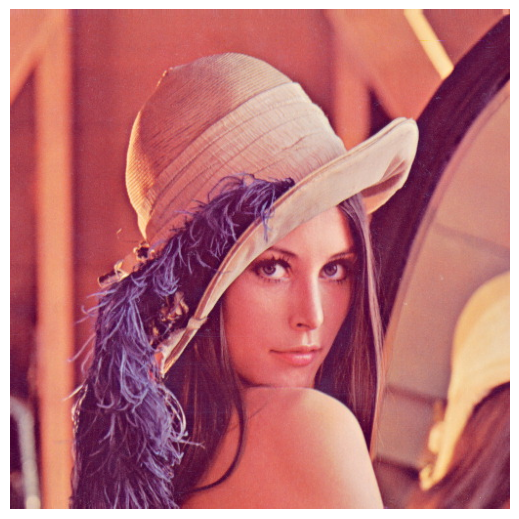

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt
import copy
%matplotlib inline
plt.style.use('default')

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=(10, 5))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_bgr(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

@pyplot
def show_gray(img):
    plt.imshow(img, cmap='gray')

def mse(img1, img2):
    return ((img1.astype(int) - img2.astype(int)) ** 2).mean()

lena = cv2.imread(str(sources_path / "lena.jpg"))
show_bgr(lena)



**1. (5 баллов)**

Загрузите изображение $lena.jpg$ (512х512). Переведите изображение в градации серого. Произведите фильтрацию данного изображения в частотной области идеальным фильтром низких частот (фильтр, обрезающий все высокочастотные составляющие Фурье-образа, находящиеся на большем расстоянии от начала координат, чем некоторое заданное расстояние $D$), идеальным фильтром высоких частот (фильтр, обрезающий все низкокочастотные составляющие Фурье-образа, находящиеся на меньшем расстоянии от начала координат, чем некоторое заданное расстояние $D$) со следующими значениями радиуса фильтров:
1. 5
2. 15
3. 30
4. 255

Для каждого фильтра постройте состыкованное изображение из следующих: исходное изображение в градациях серого, изображение Фурье-спектра (после логарифмической коррекции для лучшей визуализации), изображение Фурье-спектра после фильтрации, изображение в пространственной области после фильтрации. На выходе должно получиться 8 изображений (4 параметра фильтров х 2 типа фильтров). Функции, которые Вам потребуются: $dft$, $mulSpectrums$, $idft$.

low filter with d = 5


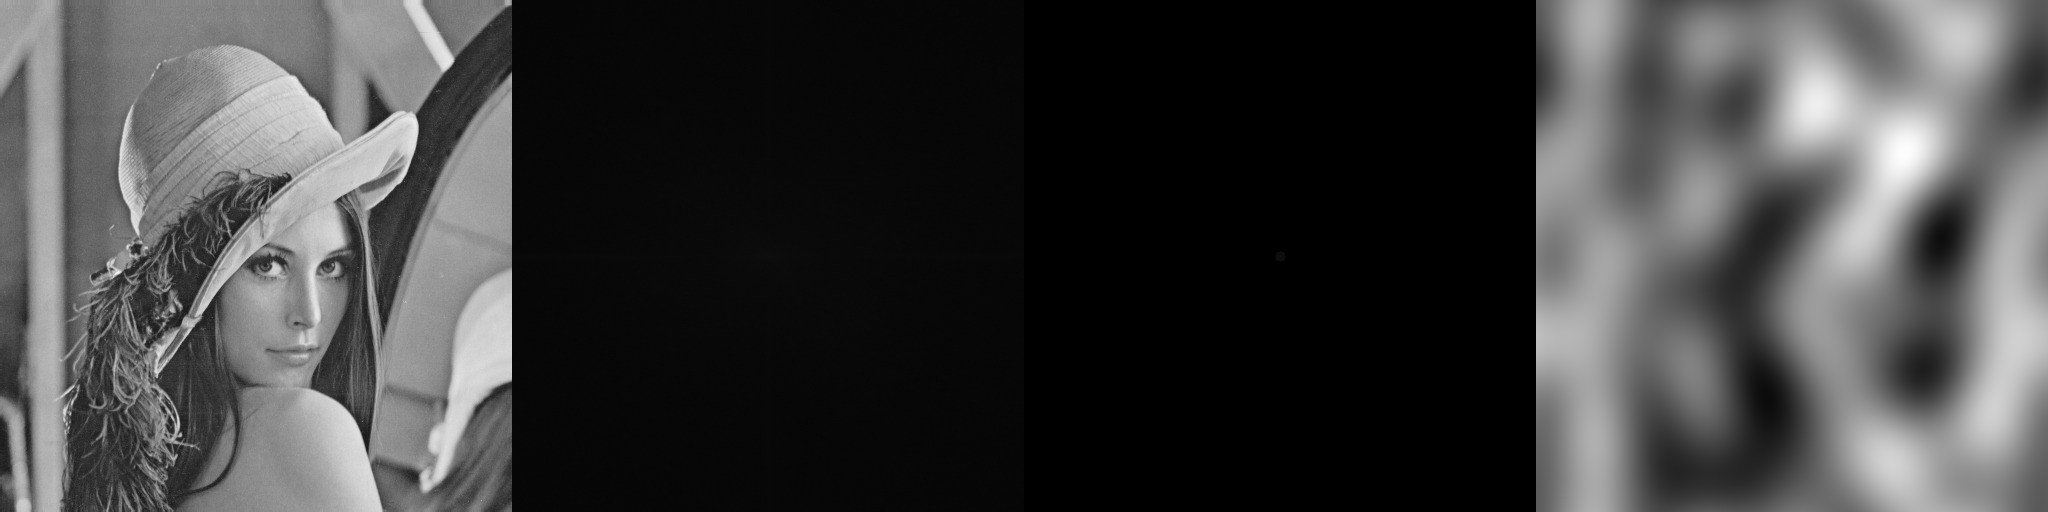

high filter with d = 5


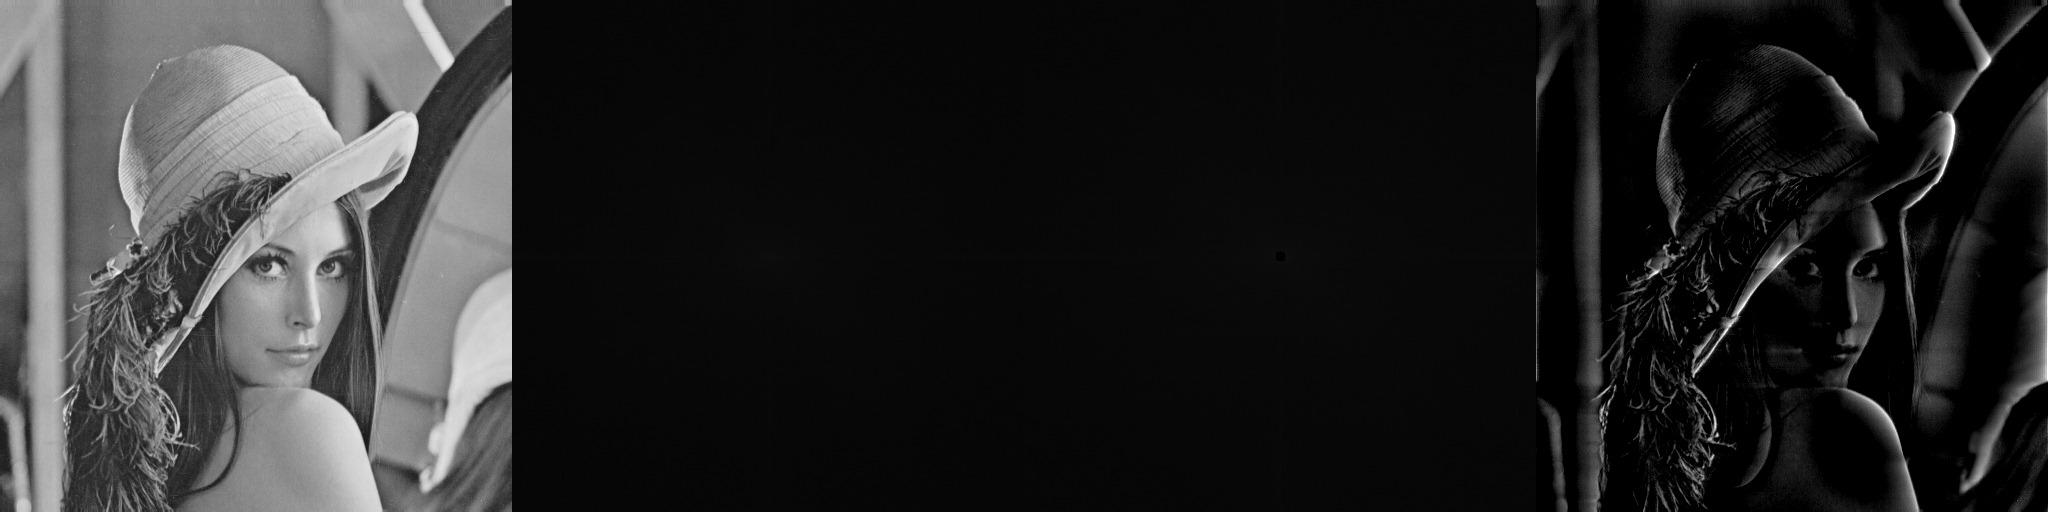

low filter with d = 15


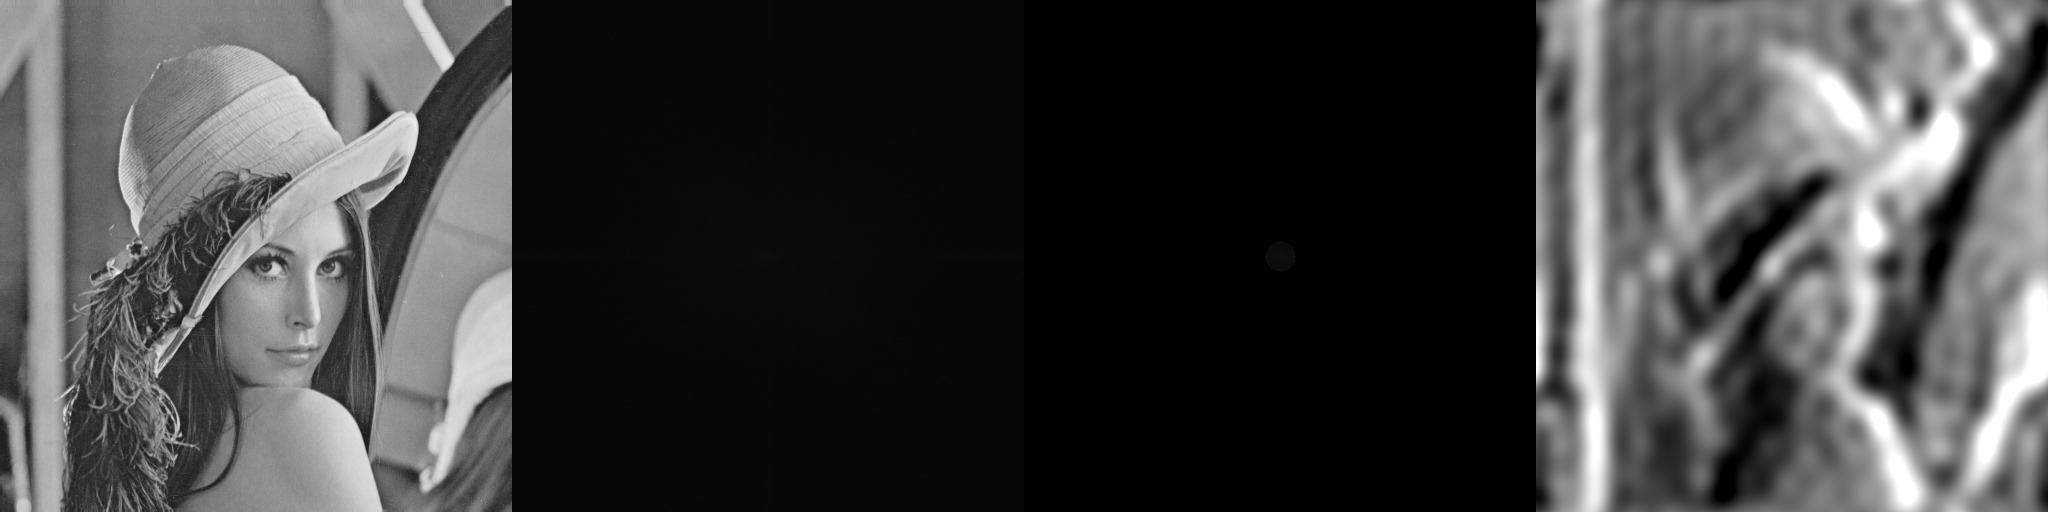

high filter with d = 15


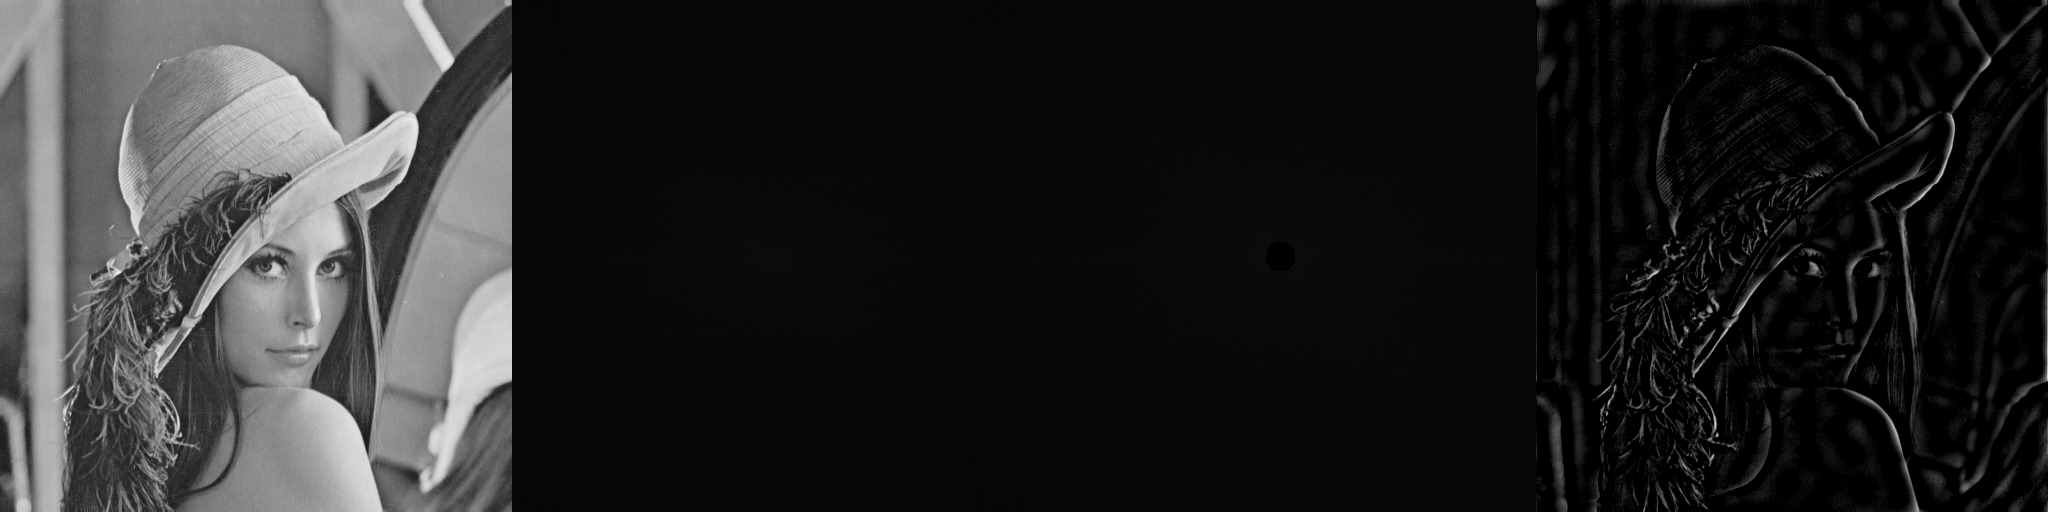

low filter with d = 30


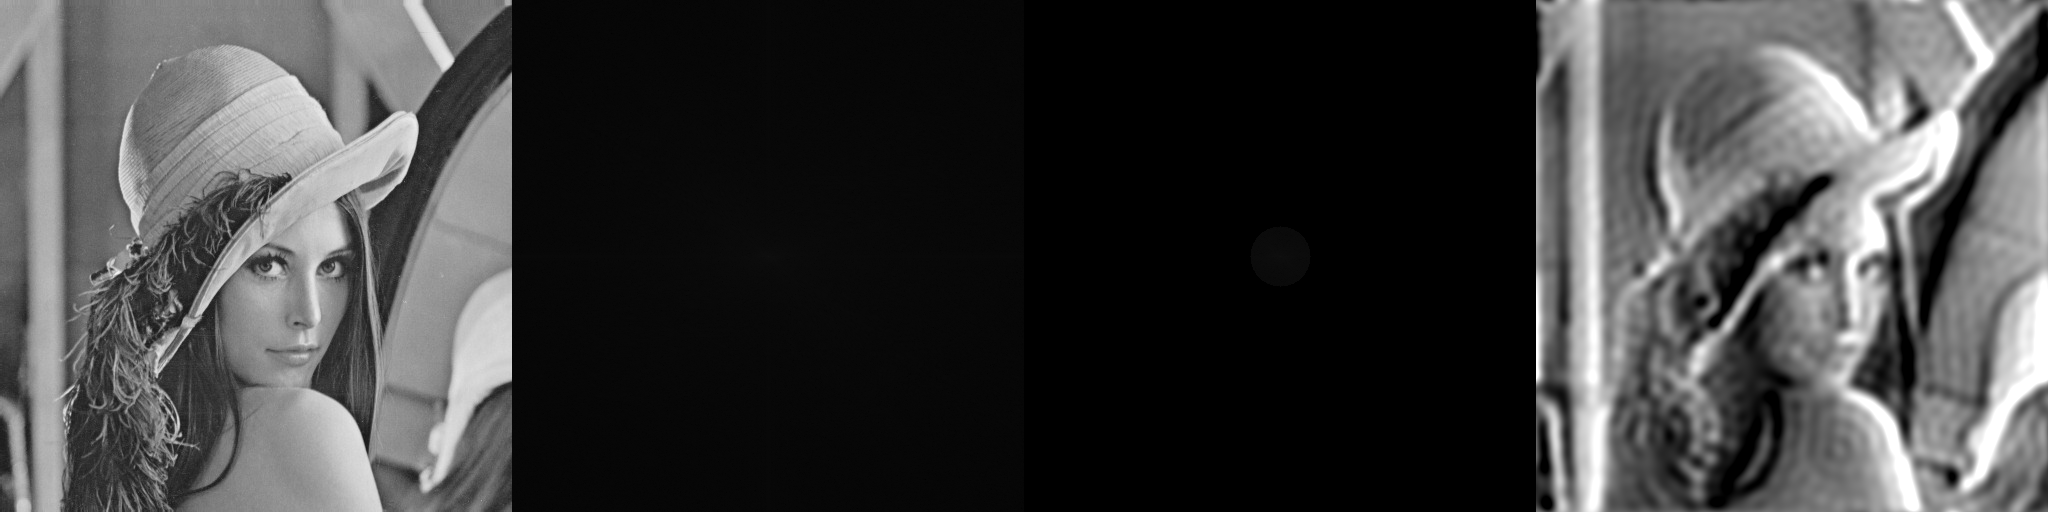

high filter with d = 30


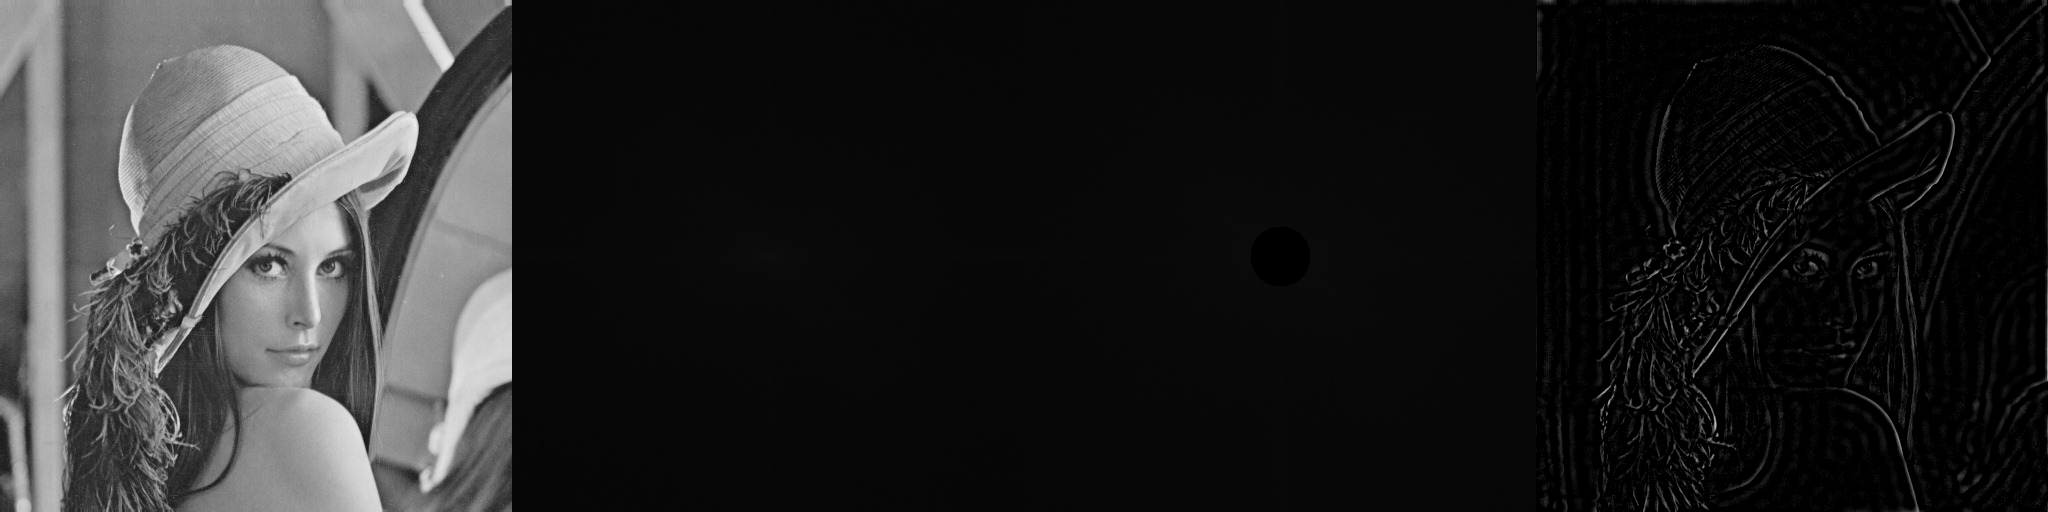

low filter with d = 255


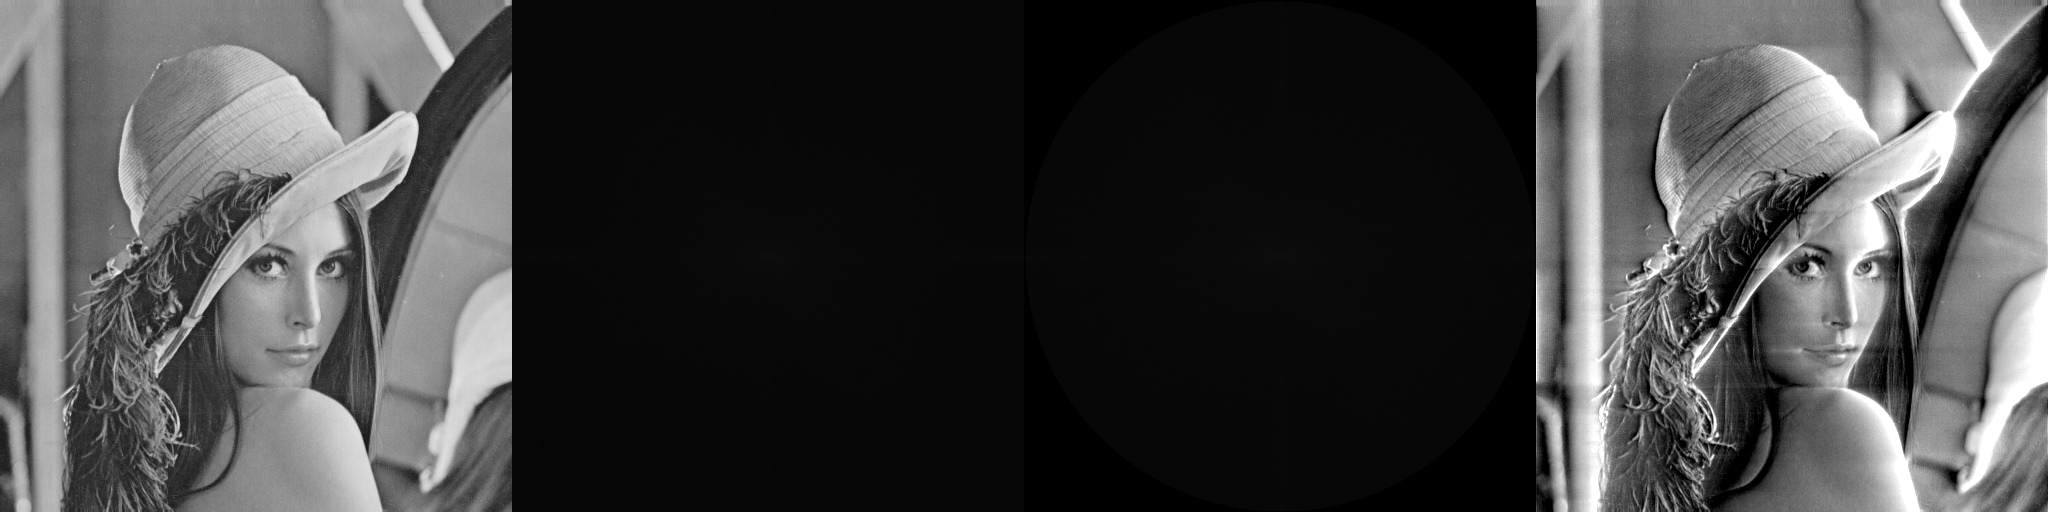

high filter with d = 255


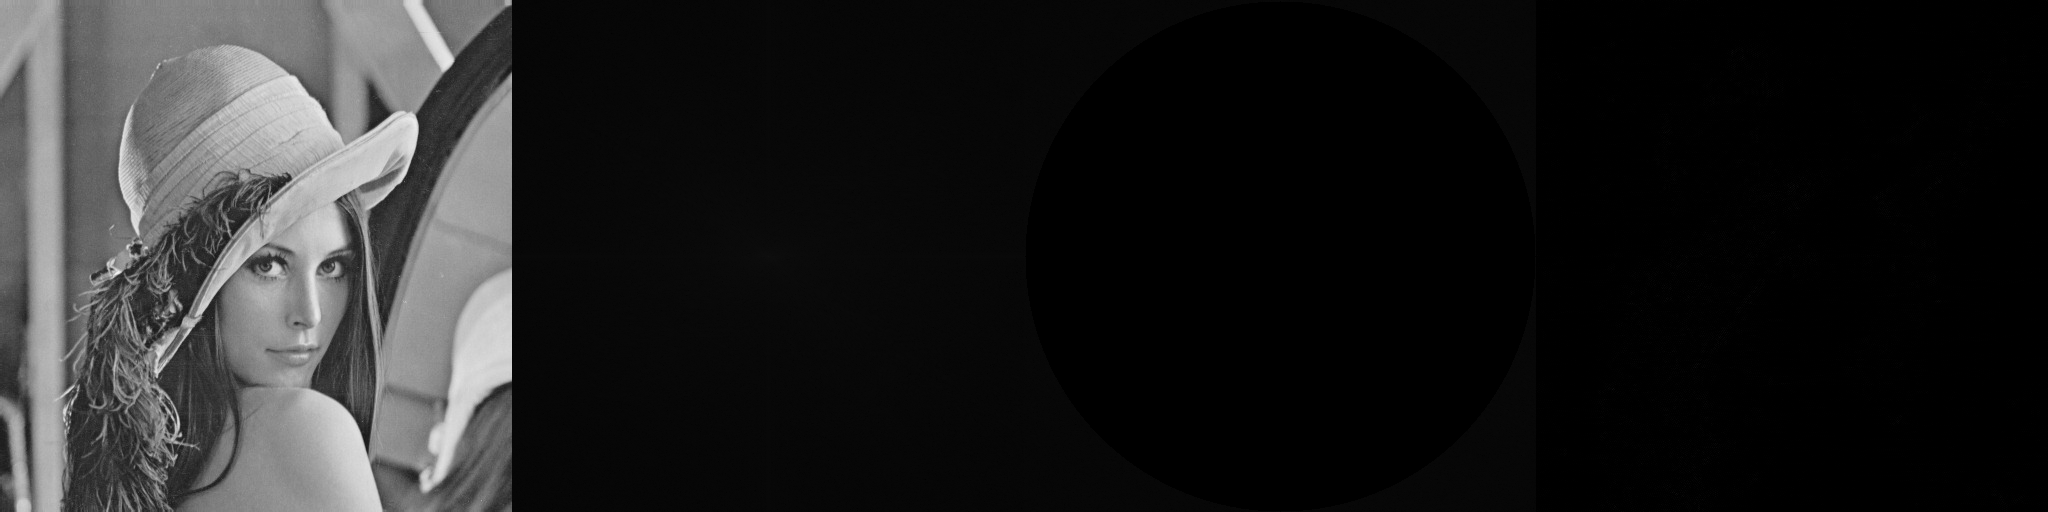

In [ ]:
from google.colab.patches import cv2_imshow

lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY).astype("float32")
D = [5, 15, 30, 255]


def low_high_filters(lena_gray, d): 
  lena_gray_shifted = copy.deepcopy(lena_gray)
  shift = np.array([[(-1)**(i+j) for j in range(lena_gray.shape[1])] 
                    for i in range(lena_gray.shape[0])])
  shift = shift.astype("float32")
  lena_gray_shifted *= shift


  dft_lena_shifted = cv2.dft(lena_gray_shifted, flags=cv2.DFT_COMPLEX_OUTPUT)
  spec = np.log(cv2.magnitude(dft_lena_shifted[:, :, 0], 
                              dft_lena_shifted[:, :, 1]))
  
  rows, cols = lena_gray.shape
  low_filter =  np.zeros((rows, cols, 2), np.float32)
  high_filter = np.ones((rows, cols, 2), np.float32)

  crow, ccol = rows//2, cols//2 
  # low_filter[crow-d:crow+d, ccol-d:ccol+d, :] = 1 
  # high_filter[crow-d:crow+d, ccol-d:ccol+d, :] = 0
  for i in range(rows):
    for j in range(cols):
      if np.sqrt((i-crow)**2 + (j-ccol)**2) <= d:
        low_filter[i, j, :] = 1
        high_filter[i, j, :] = 0


  
  dft_filtered_low = cv2.mulSpectrums(dft_lena_shifted, low_filter, flags=0)
  dft_filtered_high = cv2.mulSpectrums(dft_lena_shifted, high_filter, flags=0)

  low_filt_spec = np.log(cv2.magnitude(dft_filtered_low[:, :, 0], 
                              dft_filtered_low[:, :, 1]) + 1e-8)
  high_filt_spec = np.log(cv2.magnitude(dft_filtered_high[:, :, 0], 
                              dft_filtered_high[:, :, 1]) + 1e-8)
  
  img_filtered_low = cv2.idft(dft_filtered_low, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
  img_filtered_high = cv2.idft(dft_filtered_high, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
  
  img_filtered_low *= shift                                              
  img_filtered_high *= shift

  return spec, low_filt_spec, img_filtered_low, high_filt_spec, img_filtered_high

for d in D:
  spec, low_filt_spec, img_filtered_low, high_filt_spec, img_filtered_high = low_high_filters(lena_gray, d)

  low_collage = np.hstack([lena_gray, spec, low_filt_spec, img_filtered_low])
  high_collage = np.hstack([lena_gray, spec, high_filt_spec, img_filtered_high])
  print("low filter with d =", d)
  #show_gray(low_collage)
  cv2_imshow(low_collage)
  print("high filter with d =", d)
  #show_gray(high_collage)
  cv2_imshow(high_collage)

**2. (5 баллов)**

Удалите диагональные полоски с изображения $lena\_diagonal.jpg$. Вычислите среднеквадратичную ошибку (mean squared error, $MSE$, \url{http://en.wikipedia.org/wiki/Mean_squared_error}) для полученного результата и изображения $lena\_gray\_512.tif$. Задача будет засчитана при $MSE < 1500$.

3484.66450881958


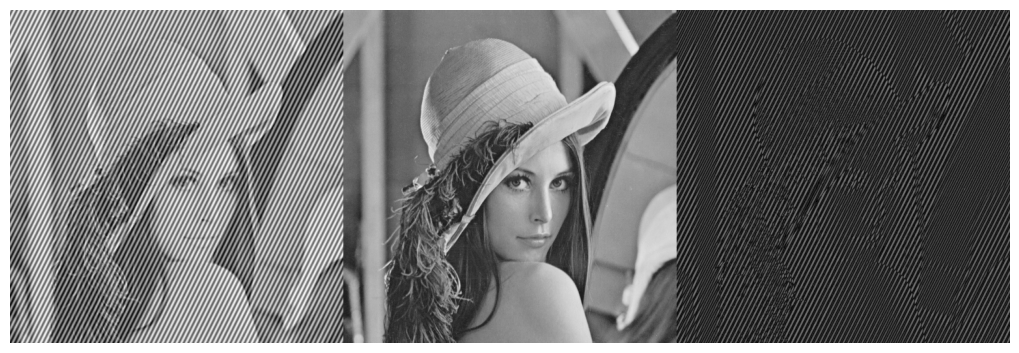

In [ ]:
lena_diag = cv2.imread(str(sources_path / "lena_diagonal.jpg"), 0)
lena_gray_fix = cv2.imread(str(sources_path / "lena_gray_512.tif"), 0)

print(mse(lena_diag, lena_gray_fix))
show_gray(np.hstack([lena_diag.astype(int), lena_gray_fix.astype(int), np.abs(lena_diag.astype(int) - lena_gray_fix.astype(int))]))

1497.3317184448242


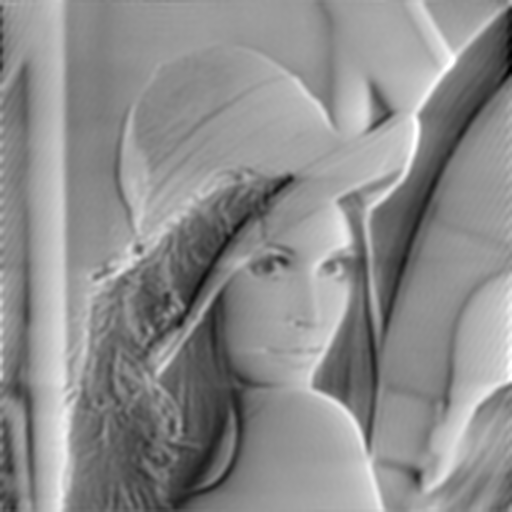

In [ ]:
lena_diag32 = lena_diag.astype("float32")
spec, low_filt_spec, img_filtered_low, high_filt_spec, img_filtered_high = low_high_filters(lena_diag32, 70)
k = 5
kernel = np.ones((k,k))/k**2
res = cv2.filter2D(img_filtered_low.astype("float64"), -1, kernel)
print(mse(res, lena_gray_fix))
cv2_imshow(res)

964.7329902648926


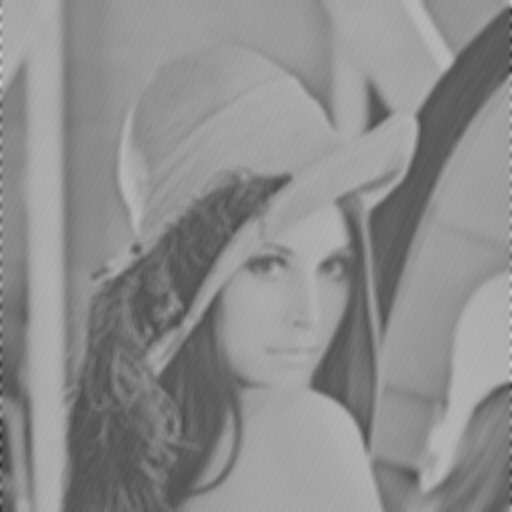

In [ ]:
k = 7
kernel = np.ones((k,k))/k**2
res = cv2.filter2D(lena_diag.astype("float64"), -1, kernel)
print(mse(res, lena_gray_fix))
cv2_imshow(res)

**3. (10 баллов)**

Теперь предложите решение, которое бы работало для любого шума подобной природы. (синусоида некотрой частоты под некоторым углом) Смоделируйте изображение с шумом и предложите универсальный алгоритм, который решит задачу. 
Тот, у кого по результатам проверки будет наименьшее значение MSE для предлженной картинки, получит призовую шоколадку (раньше мы раздавали призовые баллы, но теперь у нас концепция фиксированного максимального количества баллов)
Учтите, что помимо синусоидального шума, могут быть применены другие преобразования яркости.

---

Уточнение того, что требуется сделать:

* написать параметризованный генератор шума, которому можно задать произвольный угол, частоту полос и силу перекрытия, и получить шум с заданными параметрами

* усовершенствовать алгоритм из второй задачи, чтобы он работал на произвольных параметрах шума; тут полезно сделать интерактивный виджет, с помощью которого можно менять параметры шума и смотреть как справляется с ним алгоритм; интерактивный виджет проще всего сделать так:

    ```python
    from ipywidgets import interact

    @interact(angle=(0, 360, 1), freq=(1, 64, 1))
    def anim_general_solution(angle=45, freq=32):
        # visualization code here
    ```

* после обобщенным алгоритмом отчистить изображение из задачи 2 и посчитать MSE с чистым изображением, по этому MSE и будет конкурс за призовую шоколадку

In [ ]:
# your code here

**4. (5 баллов)**

Подавите шум на изображении $lena\_color\_512\_noise.tif$. Вычислите среднеквадратичную ошибку ($MSE$) для полученного результата и изображения $lena\_color\_512.tif$. Задача будет засчитана при $MSE < 150$. Тот, у кого по результатам проверки будет наименьшее значение $MSE$ среди всех студентов для этой задачи, получит призовую шоколадку.

2184.1810162862143


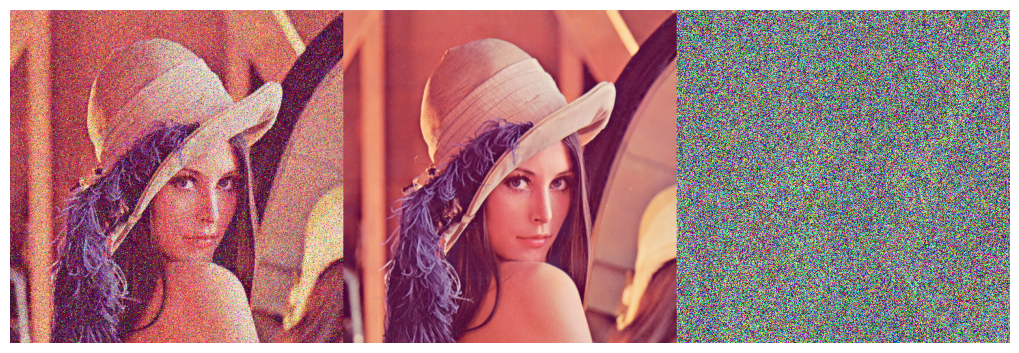

In [ ]:
img_noised = cv2.imread(str(sources_path / "lena_color_512-noise.tif"))
img_colored = cv2.imread(str(sources_path / "lena_color_512.tif"))

print(mse(img_noised, img_colored))
show_bgr(np.hstack([img_noised, img_colored, np.abs(img_noised - img_colored)]))

In [ ]:
k = 3
kernel = np.ones((k,k))/k**2
# res = cv2.filter2D(img_noised.astype("float64"), -1, kernel)
res = cv2.medianBlur(img_noised, 7)
res = cv2.filter2D(res, -1, kernel)
print(mse(res, img_colored))

149.25020599365234


**5. (5 баллов)**

Выделите границы на изображении **cat.jpg**:

* при помощи градиента и фильтров собеля
* при помощи лапласиана
* используя алгоритм $canny$

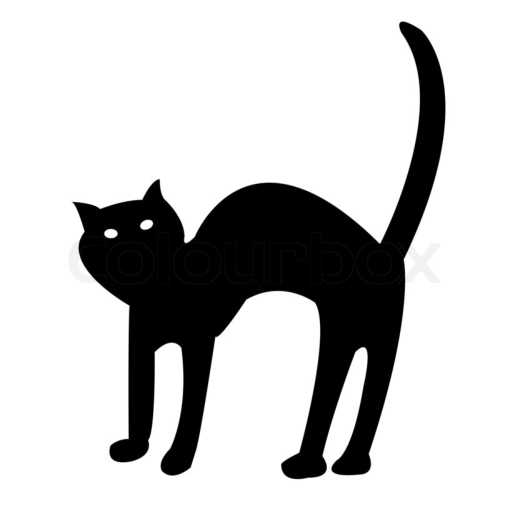

In [ ]:
img = cv2.imread(str(sources_path / "cat.jpg"), 0)
show_gray(img)

при помощи градиента и фильтров собеля

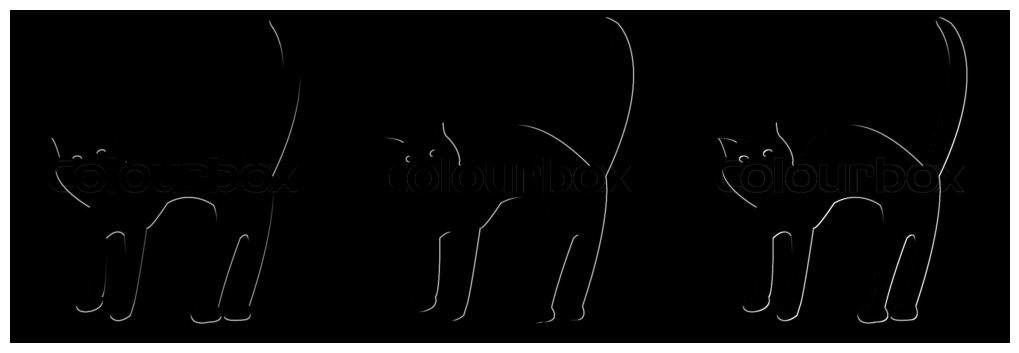

In [ ]:
ker1 = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
ker2 = ker1.T
res1 = cv2.filter2D(img, -1, ker1)
res2 = cv2.filter2D(img, -1, ker2)
res = np.sqrt(res1.astype("float64")**2 + res2.astype("float64")**2)
show_gray(np.hstack([res1,res2,res]))

при помощи лапласиана

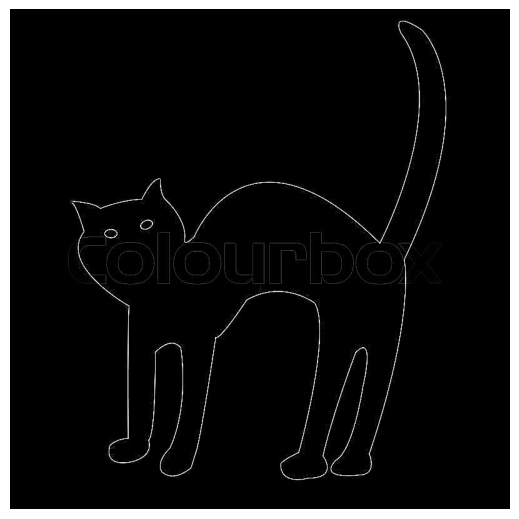

In [ ]:
ker = np.array([[-1,-1,-1],[-1,8,-1], [-1,-1,-1]])
res = cv2.filter2D(img, -1, ker)
show_gray(res)

используя алгоритм  canny

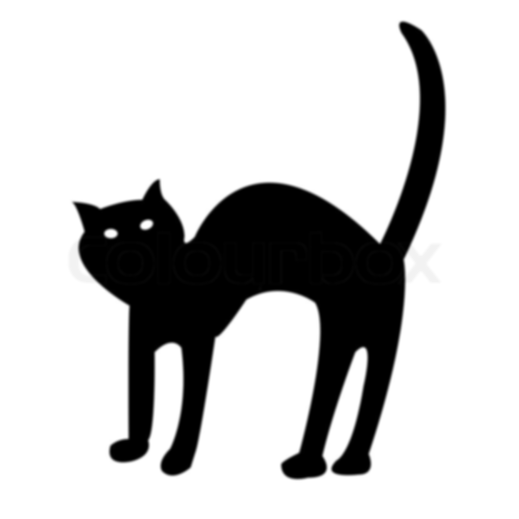

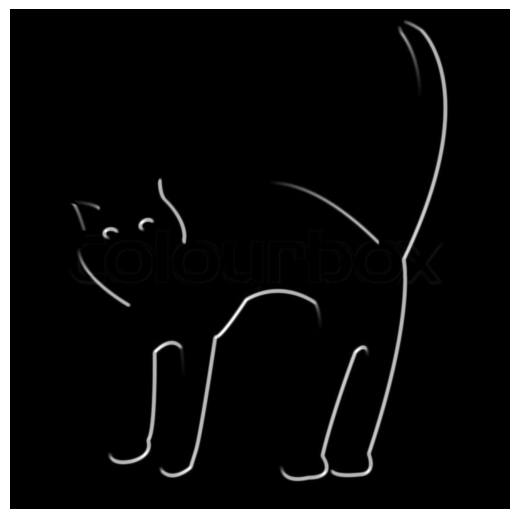

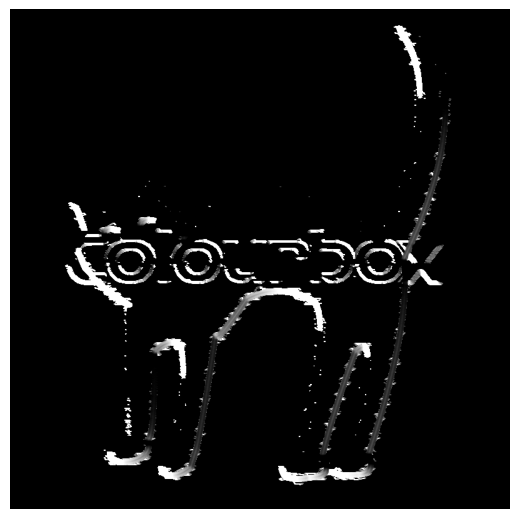

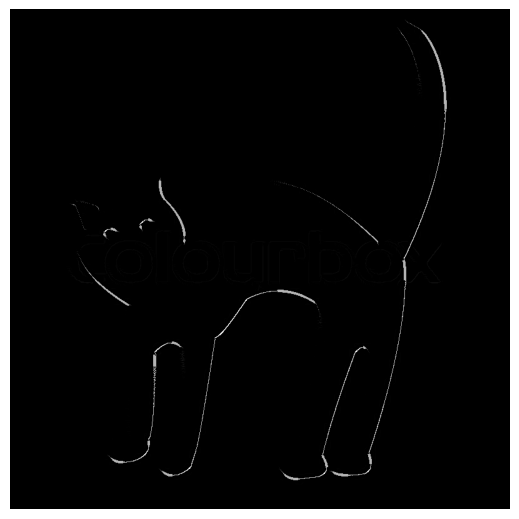

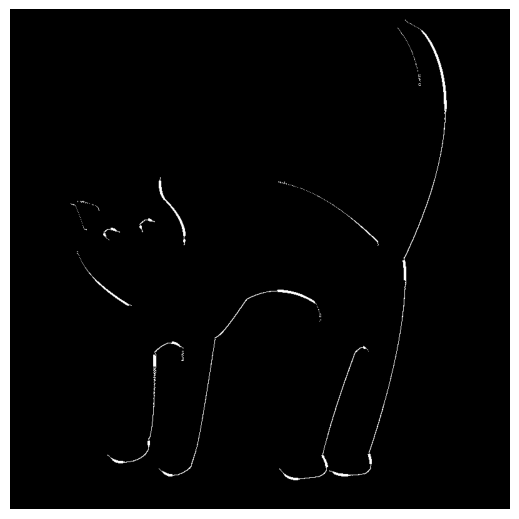

In [ ]:
import sys
sys.setrecursionlimit(100000)


def hysteresis_thresholding(suppressed, low_threshold, high_threshold):
    h, w = suppressed.shape
    visited = np.zeros((h, w))
    edges = np.zeros((h, w))

    for i in range(h):
        for j in range(w):
            if visited[i, j] == 0 and suppressed[i, j] > high_threshold:
                dfs(suppressed, visited, edges, i, j, low_threshold, high_threshold)

    return edges.astype("uint8")


def dfs(suppressed, visited, edges, i, j, low_threshold, high_threshold):
    visited[i, j] = 1
    edges[i, j] = 1

    for di in range(-1, 2):
        for dj in range(-1, 2):
            if i+di >= 0 and i+di < suppressed.shape[0] and j+dj >= 0 and j+dj < suppressed.shape[1]:
                if visited[i+di, j+dj] == 0 and suppressed[i+di, j+dj] > low_threshold:
                    if suppressed[i+di, j+dj] > high_threshold:
                        dfs(suppressed, visited, edges, i+di, j+dj, low_threshold, high_threshold)
                    else:
                        visited[i+di, j+dj] = 1
                        edges[i+di, j+dj] = 1



def canny(img, sigma = 2, ker_size = 7):
  blur_img = cv2.GaussianBlur(img, (ker_size, ker_size), sigma)
  show_gray(blur_img)

  ker_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  ker_x = ker1.T
  res_y = cv2.filter2D(blur_img, -1, ker_y)
  res_x = cv2.filter2D(blur_img, -1, ker_x)
  grad = np.sqrt(res_x.astype("float64")**2 + res_y.astype("float64")**2)
  ang = np.arctan2(res_y.astype("float64"),res_x.astype("float64"))
  show_gray(grad)
  show_gray(ang)


  #Non-max sup
  h, w = grad.shape
  suppressed = np.zeros((h, w))
  for i in range(1, h-1):
    for j in range(1, w-1):

      direction = np.degrees(ang[i, j]) % 180
      if direction < 0:
        direction += 180

      if 0 <= direction < 22.5 or 157.5 <= direction < 180:
        neighbors = [grad[i, j-1], grad[i, j+1]]
      elif 22.5 <= direction < 67.5:
        neighbors = [grad[i-1, j-1], grad[i+1, j+1]]
      elif 67.5 <= direction < 112.5:
        neighbors = [grad[i-1, j], grad[i+1, j]]
      else:
        neighbors = [grad[i-1, j+1], grad[i+1, j-1]]

      if grad[i, j] >= max(neighbors):
        suppressed[i, j] = grad[i, j]

  show_gray(suppressed)


  #hysteresis
  high_threshold = suppressed.max() * 0.09
  low_threshold = high_threshold * 0.045

  edges = hysteresis_thresholding(suppressed, low_threshold, high_threshold)
  show_gray(edges)


canny(img)